In [1]:
import pystan
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import arviz

### Load data

We are going to load the data then do a little pre-processing. The pre-processing does two things:

1. Convert the prior ranking to the range -1 and 1 based on Gelman's rescale logic outlined [here](http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf).
2. Based on the Soccer Power Index, work out which team is the favourite for each game and rank the games by those expected to be close and those not. This is mainly for plotting purposes later on and not necessary.

In [47]:
teams = np.loadtxt("../data/soccerpowerindex.txt", dtype=str)
num_teams = len(teams)

raw_prior_score = np.arange(32, 0, -1)
prior_score = (raw_prior_score - np.mean(raw_prior_score)) / (
    2 * np.std(raw_prior_score, ddof=1)
)
ranking_dict = {k: v for k, v in zip(teams, range(1, 33))}

In [48]:
data = pd.read_csv(
    "../data/worldcup2012.txt", delim_whitespace=True, header=None
)
data.columns = ["team_1", "team_1_score", "team_2", "team_2_score"]
num_games = len(data)

Work out favourites for each game and sort dataframe:

In [49]:
data["team_1_rank"] = data["team_1"].apply(lambda x: ranking_dict[x])
data["team_2_rank"] = data["team_2"].apply(lambda x: ranking_dict[x])
team_1_fave = data["team_1_rank"].values < data["team_2_rank"].values

In [50]:
def create_cols(
    df, team_1_fave_mask, t1_col, t2_col, fave_name, underdog_name
):
    df[fave_name] = df.loc[team_1_fave_mask, t1_col]
    df.loc[~team_1_fave_mask, fave_name] = df.loc[~team_1_fave_mask, t2_col]
    df[underdog_name] = df.loc[~team_1_fave_mask, t1_col]
    df.loc[team_1_fave_mask, underdog_name] = df.loc[team_1_fave_mask, t2_col]

In [51]:
create_cols(data, team_1_fave, "team_1", "team_2", "fave", "underdog")
create_cols(
    data,
    team_1_fave,
    "team_1_score",
    "team_2_score",
    "fave_score",
    "underdog_score",
)
create_cols(
    data,
    team_1_fave,
    "team_1_rank",
    "team_2_rank",
    "fave_rank",
    "underdog_rank",
)

In [53]:
data["abs_rank_diff"] = np.abs(
    data["team_1_rank"].values - data["team_2_rank"].values
)
data["fave_underdog_score_diff"] = (
    data["fave_score"].values - data["underdog_score"].values
)
data = data.sort_values(["abs_rank_diff", "fave"], ascending=[False, True])

Finally we set the degrees of freedom for the sampling distribution to be 7 (an arbitrary choice) allowing for outliers in scores but nothing too extreme.

In [54]:
degrees_of_freedom = 7

### Stan model

We are going to put team 1 always as the favourite and team 2 as the underdog:

In [56]:
stan_data = {
    "num_teams": num_teams,
    "num_games": num_games,
    "team_1_rank": data["fave_rank"].values.astype(np.uint8),
    "team_1_score": data["fave_score"].values,
    "team_2_rank": data["underdog_rank"].values.astype(np.uint8),
    "team_2_score": data["underdog_score"].values,
    "prior_score": prior_score,
    "deg_freedom": degrees_of_freedom,
}

In [16]:
model = pystan.StanModel(file="../stan_models/worldcup-no-sqrt.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0690c98284e03656f6c1e890a26458d NOW.


In [57]:
fit = model.sampling(data=stan_data)
params = fit.extract(permuted=True)
print(fit)

Inference for Stan model: anon_model_b0690c98284e03656f6c1e890a26458d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b           1.24  4.7e-3   0.28   0.71   1.06   1.24   1.42   1.81   3496    1.0
sigma_a     0.31  6.0e-3    0.2   0.02   0.15   0.29   0.44   0.75   1130    1.0
sigma_y     1.29  2.9e-3   0.16   1.02   1.18   1.28    1.4   1.64   3030    1.0
raw_a[1]   -0.06    0.01   0.92   -1.9  -0.68  -0.08   0.57   1.73   5189    1.0
raw_a[2]   -0.09    0.01   0.87  -1.82  -0.67  -0.08   0.49   1.66   4488    1.0
raw_a[3]    0.37    0.01   0.96   -1.6  -0.26   0.41    1.0   2.23   4322    1.0
raw_a[4]   -0.41    0.01   1.03  -2.43  -1.11  -0.41   0.31    1.6   4897    1.0
raw_a[5]    0.02    0.01   0.88  -1.72  -0.56   0.03   0.61   1.72   5707    1.0
raw_a[6]    0.33    0.01    0.9  -1.41  -0.28   0.32   0.95   2.08   4333    1.0
r

In [58]:
arviz_inf = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(arviz_inf)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

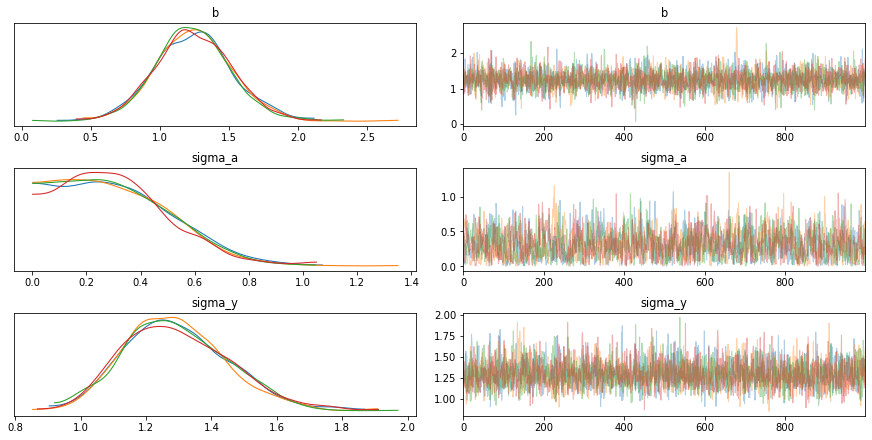

In [62]:
arviz.plot_trace(fit, var_names=("b", "sigma_a", "sigma_y"));

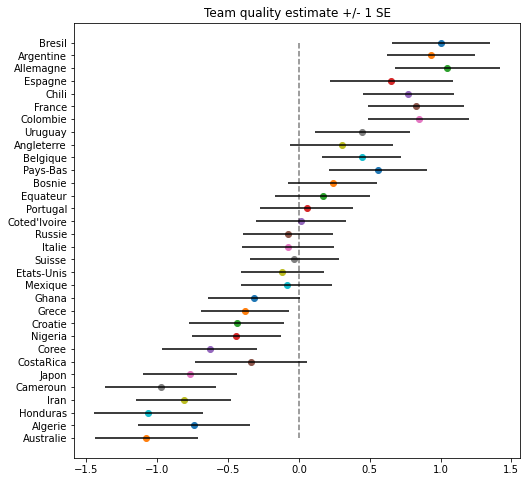

In [59]:
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(num_teams):
    a_mean = params["a"][:, i].mean()
    a_sd = float(summary_df.loc[summary_df["parameter"] == f"a[{i}]", "sd"])
    ax.scatter(a_mean, i + 1)
    ax.hlines(i + 1, a_mean - a_sd, a_mean + a_sd)

plt.vlines(0, 1, num_teams, linestyle="--", alpha=0.5)
plt.gca().invert_yaxis()
plt.yticks(range(1, num_teams + 1), teams)
plt.title("Team quality estimate +/- 1 SE");

We now plot the 95% predictive interval for each game's score difference based on the model fit.

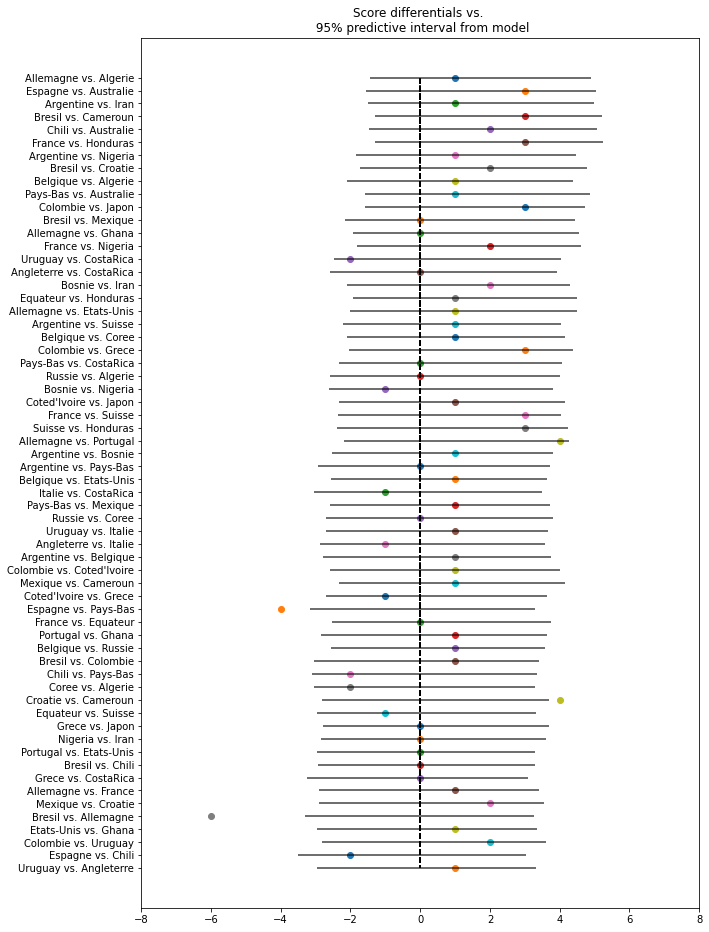

In [60]:
q = 0.95

games = [
    f"{a} vs. {b}"
    for a, b in zip(data["fave"].values, data["underdog"].values)
]
fig, ax = plt.subplots(figsize=(10, 16))
for i in range(num_games):
    lq, uq = np.quantile(
        params["ypred"][:, i], q=[(1 - q) / 2, q + (1 - q) / 2]
    )
    ax.scatter(data["fave_underdog_score_diff"].values[i], i + 1)
    ax.hlines(i + 1, lq, uq, alpha=0.75)

    plt.vlines(0, 1, num_games, linestyle="--", alpha=0.5)
plt.gca().invert_yaxis()
plt.xlim(-8, 8)
plt.yticks(range(1, num_games + 1), games)
plt.title(
    f"Score differentials vs. \n {q*100:.0f}% predictive interval from model"
);